# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:


# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.06KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

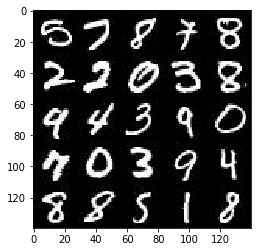

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

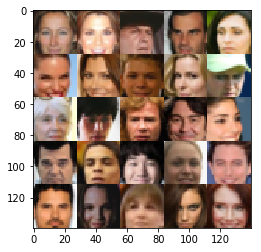

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests
import numpy as np

def model_inputs(image_width, image_height, image_channels, z_dim):
    real_inputs = tf.placeholder(tf.float32,shape=[None,image_width,image_height,image_channels])
    z_inputs = tf.placeholder(tf.float32,shape=[None,z_dim])
    learn_rate = tf.placeholder(tf.float32)
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return real_inputs, z_inputs, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    def conv_layer(inputs,filters,batch_norm=True,alpha=0.01,k_size=5,stride=2,padding="same"):
        layer= tf.layers.conv2d(inputs,filters,k_size,stride,padding)
        if batch_norm:
            layer = tf.layers.batch_normalization(layer, training=True)
        return tf.maximum(alpha*layer,layer)
    
    def fully_connected(layer):
        dims = np.prod(layer.shape[1:]).value
        flat  = tf.reshape(layer, (-1, dims))
        return tf.layers.dense(flat, 1)

    with tf.variable_scope("discriminator",reuse=reuse):
        layer = images
        for params in ([(56,True),(112,True),(224,False)]):
            layer = conv_layer(layer,*params)

        logits = fully_connected(layer)
        out= tf.sigmoid(logits)

        return out,logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
#Constant for label smoothing
smooth = 0.1
#Constant for leaky reLu
alpha = 0.2

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    leaky_reLu = lambda x, alpha : tf.maximum(alpha * x, x);
    conv2d_transpose = lambda x, depth : tf.layers.conv2d_transpose(x,
                                          depth,
                                          5,
                                          strides=2,
                                          padding='same')
    
    reuse = not is_train
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        conv1 = tf.layers.dense(z, 7*7*512)
        
        #starting convolutional stack
        conv1 = tf.reshape(conv1, (-1, 7, 7, 512))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leaky_reLu(conv1, alpha)
        #7x7x512 now
        
        conv2 = conv2d_transpose(conv1, 256)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = leaky_reLu(conv2, alpha)
        #14x14x256 now
        
        logits = conv2d_transpose(conv2, out_channel_dim)
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    loss_func = lambda x, y : tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y))
    
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    d_loss_real = loss_func(d_logits_real, tf.ones_like(d_model_real) * (1-smooth))
    d_loss_fake = loss_func(d_logits_fake, tf.zeros_like(d_model_fake))
    gen_loss = loss_func(d_logits_fake, tf.ones_like(d_model_fake))
    
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_var_list = tf.trainable_variables()
    g_vars = [var for var in t_var_list if var.name.startswith('generator')]
    d_vars = [var for var in t_var_list if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
NUM_IMAGES=9

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    def print_progress():
        train_loss_d = discrim_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
        train_loss_g = gener_loss.eval({z_inputs: batch_z}) 
        print("Epoch {}/{}...".format(epoch_i + 1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        

        
        
    out_channel_dim= data_shape[-1]
    real_inputs, z_inputs, _ = model_inputs(*data_shape[1:], z_dim)
    discrim_loss, gener_loss = model_loss(real_inputs, z_inputs, out_channel_dim)
    discrim_opt,  gener_opt = model_opt(discrim_loss, gener_loss, learning_rate, beta1)

    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    step= 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2.0 # NOTE: Normalizes image ranges
                batch_z= np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(discrim_opt,feed_dict={real_inputs: batch_images, z_inputs: batch_z})
                sess.run(gener_opt,feed_dict={real_inputs: batch_images, z_inputs: batch_z})

                if step % 10 == 0:
                    print_progress()
                if step % 100 == 0:
                    show_generator_output(sess, NUM_IMAGES, z_inputs, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4582... Generator Loss: 2.4870
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.8590
Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 2.2239
Epoch 1/2... Discriminator Loss: 1.6755... Generator Loss: 0.4176
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.3993
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.4394
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.9241


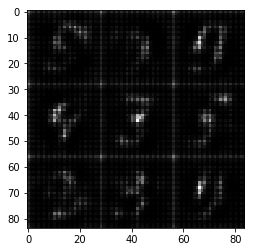

Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 1.6938
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.1883
Epoch 1/2... Discriminator Loss: 1.9668... Generator Loss: 0.3055
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.2088


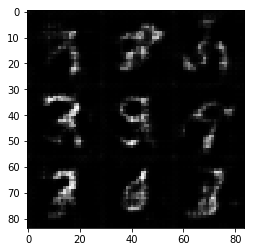

Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 1.2244
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.6098
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 2.3902
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.5982
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.9168


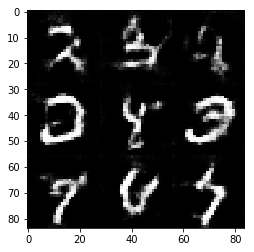

Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 1.2527
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 1.1021


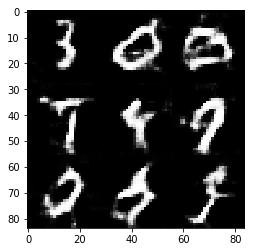

Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 1.1646
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 2.1077
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.3561
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.5068
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 2.4567
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 1.1241
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 2.1870
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.9169
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 2.2493


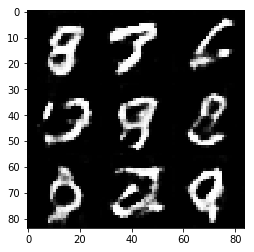

Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.4871... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.5566
Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.8886... Generator Loss: 1.6508
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 2.1864
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.9938
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.7833


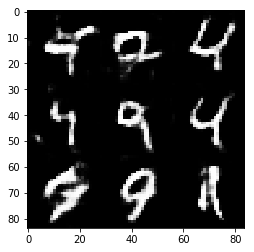

Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.6607
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.3075
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.9469
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.6723
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 1.0992


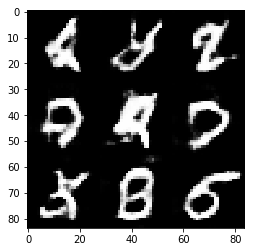

Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.6090
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 1.5037
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.4693
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 1.8788
Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 2.4885
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 1.2557
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 1.9909


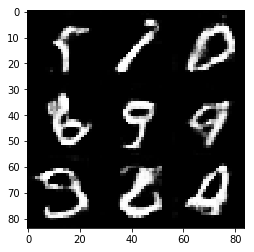

Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.3312
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 1.3913
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.9602
Epoch 1/2... Discriminator Loss: 1.5356... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 1.9242
Epoch 1/2... Discriminator Loss: 0.7464... Generator Loss: 2.2216
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.3931
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 2.2289
Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.5312


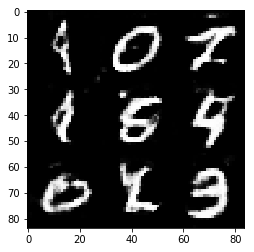

Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.3721
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 0.6982... Generator Loss: 1.7072
Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 1.1701
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.6680
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.2769
Epoch 2/2... Discriminator Loss: 2.0577... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.4540


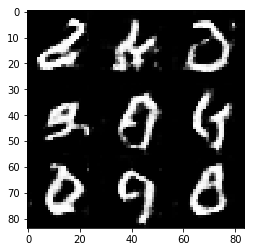

Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 1.7990
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.9803
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 1.8151
Epoch 2/2... Discriminator Loss: 1.4867... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.5649
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 1.3098


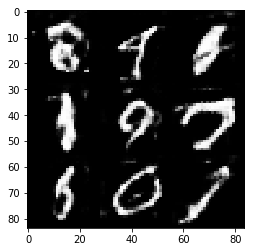

Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 1.0659
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.5217
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 3.0874
Epoch 2/2... Discriminator Loss: 0.6955... Generator Loss: 1.8326
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 2.8276
Epoch 2/2... Discriminator Loss: 0.5659... Generator Loss: 2.3269
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.4421
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 1.1831


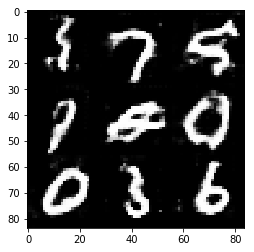

Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.9779
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 2.0136
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.9496
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 2.0373
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.6657
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 2.3626
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 2.0793
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 1.3167


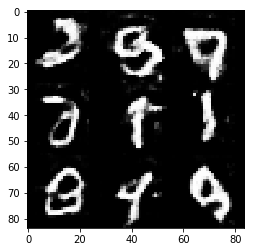

Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.4210
Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 2.1484
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 1.3232
Epoch 2/2... Discriminator Loss: 0.6351... Generator Loss: 1.8598
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.7915
Epoch 2/2... Discriminator Loss: 1.0598... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 2.0950
Epoch 2/2... Discriminator Loss: 0.5788... Generator Loss: 2.1868
Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.8218


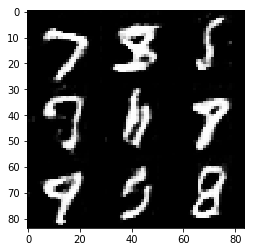

Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.8035
Epoch 2/2... Discriminator Loss: 0.6467... Generator Loss: 1.7553
Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 2.5259
Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.5253
Epoch 2/2... Discriminator Loss: 0.6979... Generator Loss: 1.6590
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.9702
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.8137
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 2.3371
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.4668


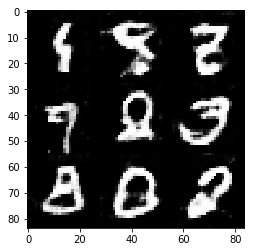

Epoch 2/2... Discriminator Loss: 0.5465... Generator Loss: 2.3067
Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 2.3297
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 2.4591
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 2.2449
Epoch 2/2... Discriminator Loss: 0.5126... Generator Loss: 2.6388
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 3.3256
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 1.9351
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 1.7004
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 2.0655
Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 0.9648


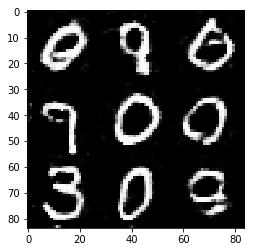

Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 2.2549
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 1.0169
Epoch 2/2... Discriminator Loss: 0.6247... Generator Loss: 1.9479
Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 1.9527
Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 2.2462
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.3692
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.9197
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 2.2947
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 1.5687
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 3.0770


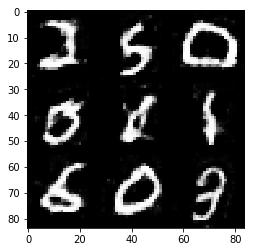

Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 2.3496
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 2.6170
Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.8815
Epoch 2/2... Discriminator Loss: 0.4922... Generator Loss: 2.6899
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 2.3248
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.6495
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 2.1391
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.4890
Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.8905


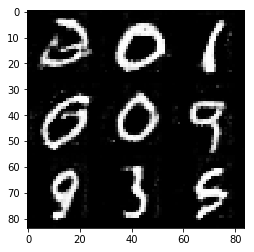

Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 2.4765
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.7788
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 2.0983
Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 2.3070
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 3.0885
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 2.4098


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 2.7512
Epoch 1/2... Discriminator Loss: 0.5260... Generator Loss: 3.1250
Epoch 1/2... Discriminator Loss: 0.5318... Generator Loss: 2.2646
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 1.7271... Generator Loss: 0.3732
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.8724
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.4001
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 0.4806... Generator Loss: 2.8671


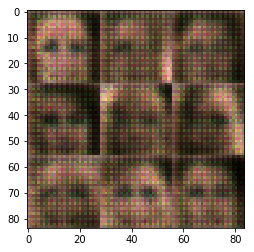

Epoch 1/2... Discriminator Loss: 0.5046... Generator Loss: 2.5699
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 2.7343
Epoch 1/2... Discriminator Loss: 2.2039... Generator Loss: 4.3648
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.3204
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 5.0688
Epoch 1/2... Discriminator Loss: 1.8124... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.6264
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.6469


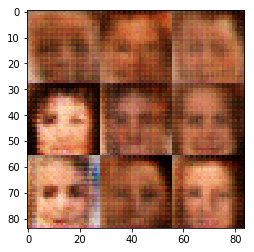

Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 3.6036
Epoch 1/2... Discriminator Loss: 1.7920... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 2.0125
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.6938
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.3229
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 1.4077


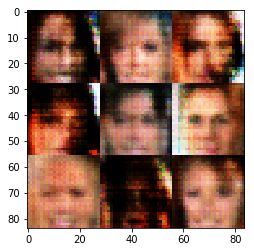

Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 2.4104
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 2.3591
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 5.6552
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.8889
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.4686
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 1.8490
Epoch 1/2... Discriminator Loss: 0.3696... Generator Loss: 4.7416


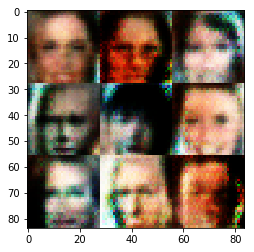

Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 3.3203
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.6418
Epoch 1/2... Discriminator Loss: 0.4044... Generator Loss: 4.2985
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 2.9390
Epoch 1/2... Discriminator Loss: 0.9298... Generator Loss: 1.0016
Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 1.8354
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.0834
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.1220
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.8031


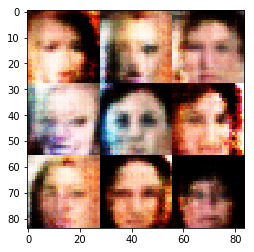

Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 5.6000
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 3.2962
Epoch 1/2... Discriminator Loss: 0.4511... Generator Loss: 2.5694
Epoch 1/2... Discriminator Loss: 0.6527... Generator Loss: 2.6367
Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 1.7920
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 1.5123
Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 0.6286... Generator Loss: 2.0446
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 1.8813


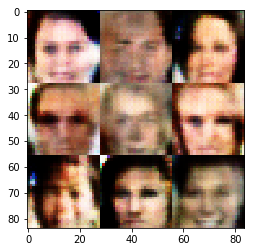

Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 3.6624
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 2.7243
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 2.8841
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 3.1808
Epoch 1/2... Discriminator Loss: 0.4534... Generator Loss: 2.8397
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 1.2405
Epoch 1/2... Discriminator Loss: 0.7049... Generator Loss: 4.6362
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 0.4407... Generator Loss: 2.9377


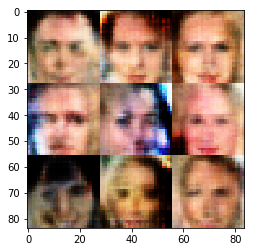

Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 2.2242
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 3.2181
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 1.7909
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 1.2152
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 2.6926
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 5.3532
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 1.3820
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.2317


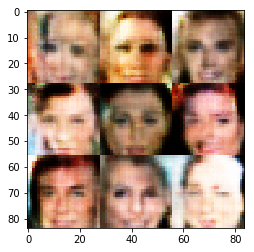

Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.3101
Epoch 1/2... Discriminator Loss: 1.7057... Generator Loss: 4.3700
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 2.1267
Epoch 1/2... Discriminator Loss: 0.4960... Generator Loss: 2.3886
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 2.2309
Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 2.0529
Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 2.3261
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 4.8115
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 1.4322


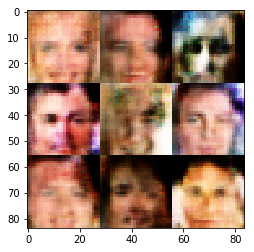

Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.8980
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 2.0117
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.3833
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.4357
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 2.2750
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 2.7559
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.2482


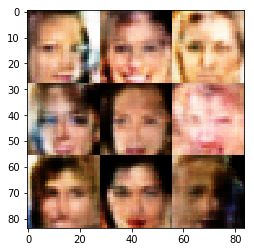

Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.3566
Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 3.5197
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 2.4098
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 2.5492
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 4.5370
Epoch 1/2... Discriminator Loss: 0.9100... Generator Loss: 1.1523
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 2.2685


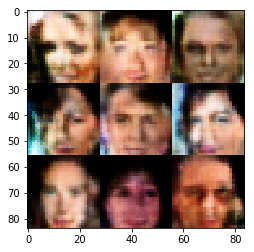

Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 2.1034
Epoch 1/2... Discriminator Loss: 0.5507... Generator Loss: 2.3782
Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.7168
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 0.9632
Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 1.8466
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 2.4952
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 2.6604
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.8216


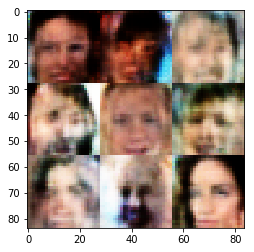

Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 2.6220
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 2.9909
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.4097
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.5258
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 2.5764
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.3182
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.7815
Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 0.6589... Generator Loss: 2.1684


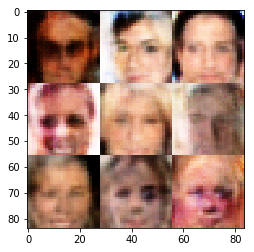

Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 2.3972
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.2269
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 0.4491... Generator Loss: 3.4830
Epoch 1/2... Discriminator Loss: 0.6122... Generator Loss: 2.2371
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 2.4310
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 4.5701
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.2816
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 2.7481


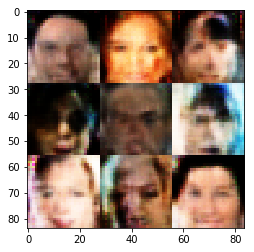

Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 2.8118
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.2535
Epoch 1/2... Discriminator Loss: 0.5012... Generator Loss: 4.1409
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 3.6204
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 1.2300
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 4.0860
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 2.6971
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 3.8985
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.2451


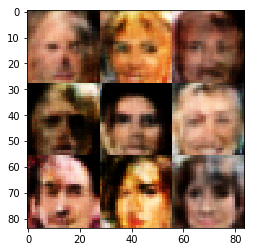

Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.6509
Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 2.3569
Epoch 1/2... Discriminator Loss: 0.6098... Generator Loss: 2.5503
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 2.0520
Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 0.4965... Generator Loss: 2.6763
Epoch 1/2... Discriminator Loss: 0.6492... Generator Loss: 1.9180
Epoch 1/2... Discriminator Loss: 1.9006... Generator Loss: 0.3434
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 0.7870... Generator Loss: 1.3446


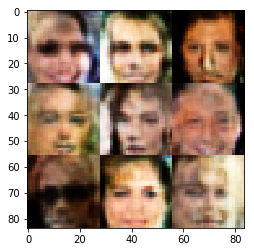

Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 0.4641... Generator Loss: 3.8452
Epoch 1/2... Discriminator Loss: 1.7890... Generator Loss: 4.0406
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.3763
Epoch 1/2... Discriminator Loss: 0.5042... Generator Loss: 2.5953
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 2.9544
Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 2.0907
Epoch 1/2... Discriminator Loss: 1.7117... Generator Loss: 2.6283
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.1826
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.8663


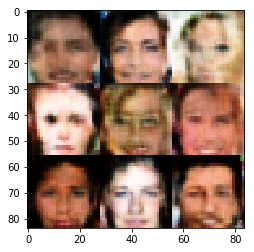

Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.4509
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.8476
Epoch 1/2... Discriminator Loss: 0.6644... Generator Loss: 4.7165
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.7446
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 1.5049
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.4971
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.6120
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 1.5372


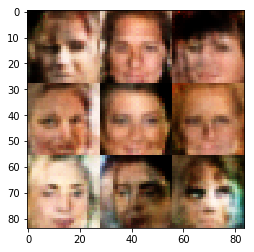

Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 2.9163
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 2.4170
Epoch 1/2... Discriminator Loss: 0.7293... Generator Loss: 1.8798
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 3.8798
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 2.4958
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 3.0040
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 2.6226
Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 1.2006
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 0.9662
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.2785


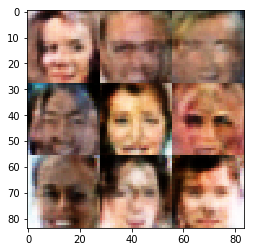

Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 4.0713
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 5.1208
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 2.6804
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.4131
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 1.8920
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.8100
Epoch 1/2... Discriminator Loss: 0.5919... Generator Loss: 2.9544
Epoch 1/2... Discriminator Loss: 0.3933... Generator Loss: 5.0870
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 1.4936


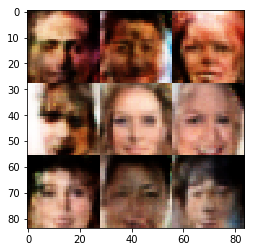

Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 1.9434
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 3.2245
Epoch 1/2... Discriminator Loss: 0.5916... Generator Loss: 3.0572
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 3.7168
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 2.0597
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 2.3156
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.3692
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 2.8058
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 1.7034
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 3.8257


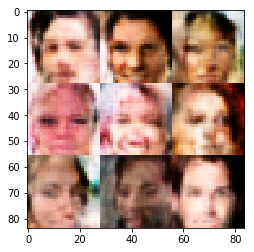

Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 1.9981
Epoch 1/2... Discriminator Loss: 0.6259... Generator Loss: 3.3366
Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 1.8516... Generator Loss: 3.8945
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 3.2730
Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 2.4929
Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 2.4686
Epoch 1/2... Discriminator Loss: 0.5519... Generator Loss: 2.6569
Epoch 1/2... Discriminator Loss: 0.5015... Generator Loss: 2.7028
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 4.9486


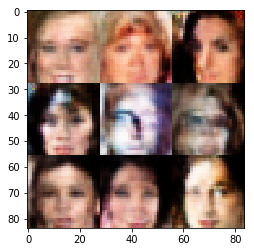

Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 1.2512
Epoch 1/2... Discriminator Loss: 0.6405... Generator Loss: 1.9054
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 2.1583
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.4678
Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 1.3515
Epoch 1/2... Discriminator Loss: 0.7060... Generator Loss: 1.7970
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 1.8460
Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.6655
Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 1.3012


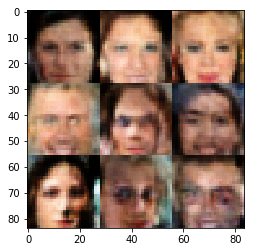

Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 3.3791
Epoch 1/2... Discriminator Loss: 0.4710... Generator Loss: 2.9996
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 2.6906
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 2.8176
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 3.6241
Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.3474
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 2.9385
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.3967
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 2.1096
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.4882


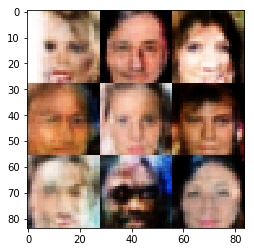

Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 0.5324... Generator Loss: 2.7780
Epoch 1/2... Discriminator Loss: 0.4281... Generator Loss: 3.6292
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 5.3813
Epoch 1/2... Discriminator Loss: 0.4208... Generator Loss: 3.9215
Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 4.0239
Epoch 1/2... Discriminator Loss: 0.3701... Generator Loss: 6.2663
Epoch 1/2... Discriminator Loss: 0.3779... Generator Loss: 4.6435
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 2.9680
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.9127


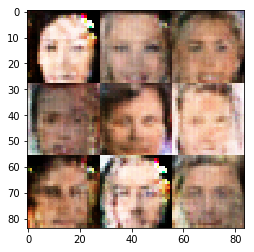

Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 2.4281
Epoch 1/2... Discriminator Loss: 0.5682... Generator Loss: 2.0752
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 3.1331
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 4.1263
Epoch 1/2... Discriminator Loss: 0.4724... Generator Loss: 2.8920
Epoch 1/2... Discriminator Loss: 0.6160... Generator Loss: 1.9093
Epoch 1/2... Discriminator Loss: 0.4600... Generator Loss: 2.9444
Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 4.0937
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 2.1052


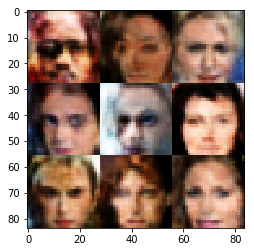

Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 2.1407
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.9136
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 1.4462
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 0.4995... Generator Loss: 3.1719
Epoch 1/2... Discriminator Loss: 0.4998... Generator Loss: 2.5108
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 3.5797
Epoch 1/2... Discriminator Loss: 0.5455... Generator Loss: 4.1313
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.6925


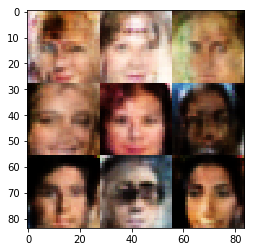

Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.6858
Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 1.7225
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 2.9040
Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 3.7926
Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 2.5125
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 3.0935
Epoch 1/2... Discriminator Loss: 2.0049... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.9240
Epoch 1/2... Discriminator Loss: 0.7687... Generator Loss: 1.5577


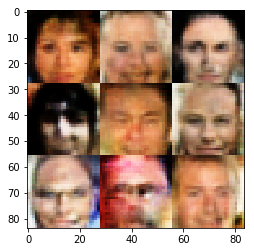

Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 1.7304
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 2.4742
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 2.2411
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 2.0025
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.3030
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 2.5365
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 2.2766
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 1.5298


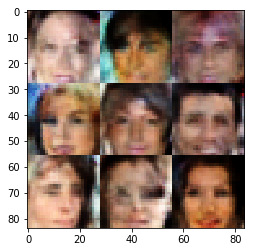

Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 3.5103
Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 3.1005
Epoch 1/2... Discriminator Loss: 1.8367... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 2.2216
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.8948
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 0.6812... Generator Loss: 1.8387
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 2.2099


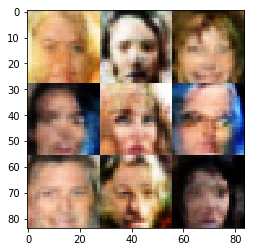

Epoch 1/2... Discriminator Loss: 0.4714... Generator Loss: 3.6484
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 2.9281
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.5512
Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 4.4422
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 3.3404
Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 2.7436
Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 4.3549
Epoch 1/2... Discriminator Loss: 0.4464... Generator Loss: 3.2472
Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 4.2654


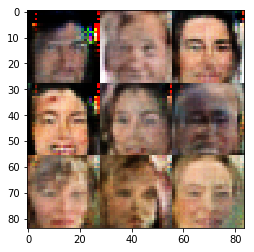

Epoch 1/2... Discriminator Loss: 0.3708... Generator Loss: 6.5958
Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 4.2057
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 2.2334
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 2.0126
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.4958
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 2.4951
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 2.9458
Epoch 2/2... Discriminator Loss: 1.8584... Generator Loss: 0.4365
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.9288


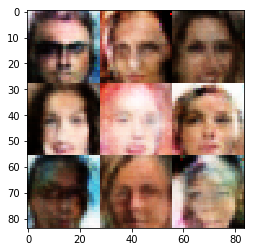

Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.4959
Epoch 2/2... Discriminator Loss: 0.6058... Generator Loss: 2.3122
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 1.8030
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.9804
Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 2.9495
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 2.5106
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 1.3543
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.7157


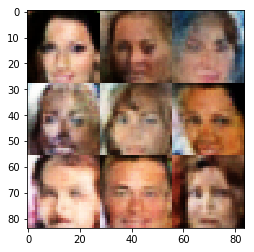

Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 1.1616
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.4665
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 4.6362
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.5401
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 1.8238
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 2.3314
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 2.1131
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.8512
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 2.2073


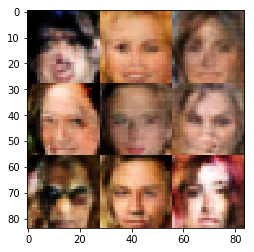

Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 2.6143
Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 2.1492
Epoch 2/2... Discriminator Loss: 0.8605... Generator Loss: 4.9003
Epoch 2/2... Discriminator Loss: 0.4814... Generator Loss: 2.7584
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 0.9282
Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 3.3306
Epoch 2/2... Discriminator Loss: 0.5706... Generator Loss: 3.0142
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 2.9250
Epoch 2/2... Discriminator Loss: 1.9789... Generator Loss: 3.2552


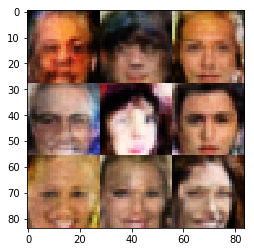

Epoch 2/2... Discriminator Loss: 0.5242... Generator Loss: 3.4860
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 2.2937
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 2.8996
Epoch 2/2... Discriminator Loss: 0.4212... Generator Loss: 5.0355
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.8543
Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 2.7914
Epoch 2/2... Discriminator Loss: 2.2907... Generator Loss: 0.3123
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.6700
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 4.7675
Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 4.1450


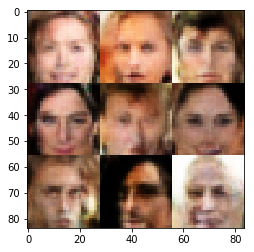

Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 2.2382
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 3.2094
Epoch 2/2... Discriminator Loss: 0.7276... Generator Loss: 5.2637
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 2.2544
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 3.4248
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 2.9241
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 2.1753
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 2.2879


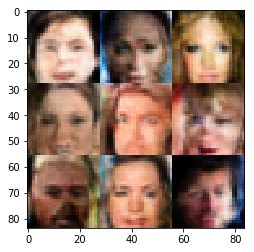

Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.2579
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.8480
Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 2.8382
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 4.1796
Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 2.4663
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.9017
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 2.0013
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.6004


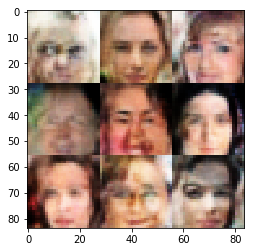

Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 2.9031
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 3.1155
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.6167
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 2.6755
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.5631
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 0.4252... Generator Loss: 3.7446
Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.9037


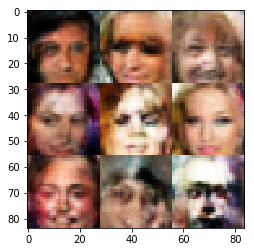

Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 2.0884
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 3.3481
Epoch 2/2... Discriminator Loss: 0.5010... Generator Loss: 2.7955
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 3.8641
Epoch 2/2... Discriminator Loss: 0.6019... Generator Loss: 2.0113
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 0.7472... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 2.5589
Epoch 2/2... Discriminator Loss: 0.4419... Generator Loss: 2.9038


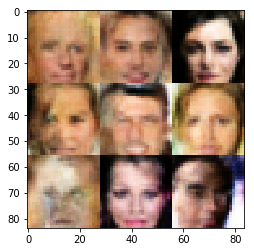

Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 2.2627
Epoch 2/2... Discriminator Loss: 0.8143... Generator Loss: 1.5186
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 2.9851
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 2.0476
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 2.6525
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 3.2904
Epoch 2/2... Discriminator Loss: 0.6123... Generator Loss: 2.1773
Epoch 2/2... Discriminator Loss: 0.4850... Generator Loss: 2.7688
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 1.7176


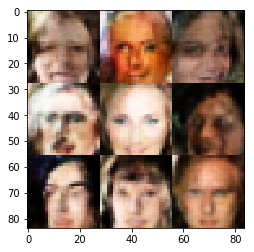

Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.2284
Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 2.3681
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 2.3895
Epoch 2/2... Discriminator Loss: 0.4433... Generator Loss: 3.1652
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.4520
Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 3.5836
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 4.8483
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 2.2524
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 1.6987


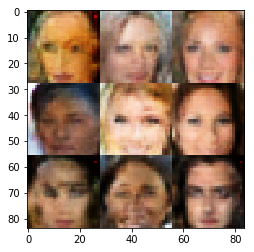

Epoch 2/2... Discriminator Loss: 0.7466... Generator Loss: 1.5509
Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.6977
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 2.1648
Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 3.4241
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 2.6097
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.7513
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 1.4036
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 1.4714


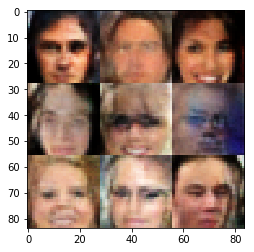

Epoch 2/2... Discriminator Loss: 0.4211... Generator Loss: 5.9082
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.9613
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 3.1142
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.2192
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.4689
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.6557
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 2.7567
Epoch 2/2... Discriminator Loss: 0.4460... Generator Loss: 3.1597
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.8143


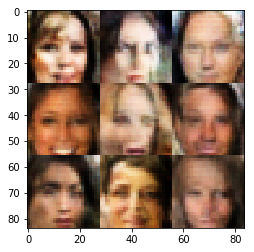

Epoch 2/2... Discriminator Loss: 0.4142... Generator Loss: 4.0919
Epoch 2/2... Discriminator Loss: 0.5836... Generator Loss: 2.8339
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 3.8861
Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 1.2215
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.6296
Epoch 2/2... Discriminator Loss: 0.6938... Generator Loss: 1.6803
Epoch 2/2... Discriminator Loss: 0.4467... Generator Loss: 3.3480
Epoch 2/2... Discriminator Loss: 0.4847... Generator Loss: 4.2424
Epoch 2/2... Discriminator Loss: 0.4236... Generator Loss: 3.5922
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.1308


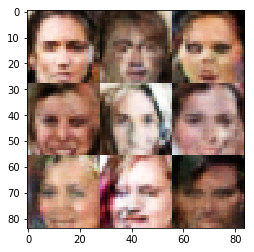

Epoch 2/2... Discriminator Loss: 0.3998... Generator Loss: 5.7814
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 2.8561
Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 4.3975
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 3.4089
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 1.0676
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 2.5382
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.8268
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 1.8720
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 2.4309


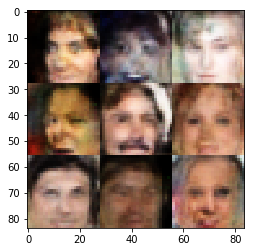

Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 2.5381
Epoch 2/2... Discriminator Loss: 0.5588... Generator Loss: 2.4819
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 1.9393
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 2.7273
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 1.9397
Epoch 2/2... Discriminator Loss: 0.5879... Generator Loss: 3.0693
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 4.2193
Epoch 2/2... Discriminator Loss: 0.4236... Generator Loss: 3.4870
Epoch 2/2... Discriminator Loss: 0.4494... Generator Loss: 3.6989


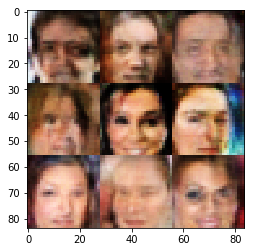

Epoch 2/2... Discriminator Loss: 3.4473... Generator Loss: 0.1150
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 1.5066
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.3351
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 5.1184
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 2.5502
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 3.0238
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 5.1290
Epoch 2/2... Discriminator Loss: 0.4215... Generator Loss: 3.8265
Epoch 2/2... Discriminator Loss: 0.4198... Generator Loss: 4.0915
Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 3.8333


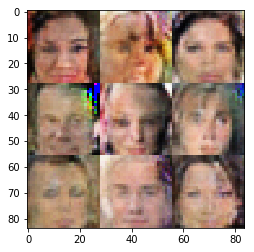

Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 6.8895
Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 7.3799
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 2.6793
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 5.9052
Epoch 2/2... Discriminator Loss: 0.3738... Generator Loss: 4.9282
Epoch 2/2... Discriminator Loss: 0.3896... Generator Loss: 4.6074
Epoch 2/2... Discriminator Loss: 0.4638... Generator Loss: 3.6309
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.7291
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 2.3654
Epoch 2/2... Discriminator Loss: 0.5847... Generator Loss: 2.1462


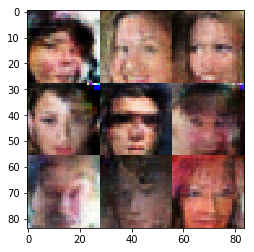

Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 3.0523
Epoch 2/2... Discriminator Loss: 0.3955... Generator Loss: 4.0452
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 4.6077
Epoch 2/2... Discriminator Loss: 0.4598... Generator Loss: 3.0056
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 2.0888
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.9299
Epoch 2/2... Discriminator Loss: 0.4004... Generator Loss: 5.5286
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.8149
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.4942
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.2716


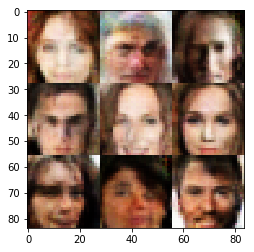

Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.4233
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.1776
Epoch 2/2... Discriminator Loss: 0.5780... Generator Loss: 2.0774
Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 1.6450
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 2.7958
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.6287


KeyboardInterrupt: 

In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.